### Predicting `y` given `x`

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

### Data Processing

In [29]:
df = pd.read_csv('data/train.csv')
df.head()

,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984


### Check if there are `na` values

In [30]:
df.isnull().values.sum()

1

In [33]:
df = df.dropna()

In [34]:
df.isnull().values.sum()

0

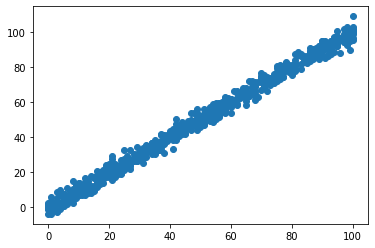

In [3]:
plt.scatter(df.x, df.y)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,  MaxAbsScaler

In [35]:
class Data(Dataset):
    def __init__(self, path, transform=None, shuffle=False):
        self.path = path
        self.shuffle = shuffle
        self.transform = transform
        
        # Scale the sparse data
        self.data = pd.read_csv(self.path)
        self.data = self.data.dropna()
        column_transformer = ColumnTransformer([
            ('min_max_scaler', MaxAbsScaler(), ['x'])
        ]).fit(self.data)
        self.xy = column_transformer.transform(self.data)
        
        if self.shuffle:
            np.random.shuffle(self.xy)
            
        self.x = self.xy[:,0]
        self.y = self.data.y.values
        self.len = self.x.shape[0]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def plot(self):
        plt.scatter(self.x, self.y)
        plt.show()
        

### Transformers

In [36]:
class ToTensor():
    def __call__(self, sample):
        x, y = sample
        return torch.tensor(x.astype('float32')), torch.tensor(y.astype('float32'))

### Train and testing data

In [37]:
train = Data(path='data/train.csv', shuffle=True, transform=ToTensor())
test = Data(path='data/test.csv', shuffle=True, transform=ToTensor())

In [38]:
train[0]

(tensor(0.2200), tensor(21.5495))

### Data Loading

In [39]:
train_set = DataLoader(
    train,
    shuffle=True,
    batch_size=10
)
test_set = DataLoader(
    test,
    shuffle=False,
    batch_size=10
)

In [40]:
in_features = 10 # the batch size 

### Model Creation

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 64)
        self.linear2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x
net = Net()
net

Net(
  (linear1): Linear(in_features=1, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)

In [53]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [56]:
EPOCHS = 100
for epoch in range(EPOCHS):
    for X, y in train_set:
        optimizer.zero_grad()
        # forward pass
        outputs = net(X.view(-1, 1))
        # Loss
        loss = criterion(outputs, y.unsqueeze_(1))
        # backward pass
        loss.backward()
        
        ## update the weights
        optimizer.step()
    if (epoch +1 ) % 10 == 0:
        print(f'Epoch: {epoch+1}/{EPOCHS}, loss: {loss:.3f}')

Epoch: 10/100, loss: 1207.961
Epoch: 20/100, loss: 1116.373
Epoch: 30/100, loss: 870.341
Epoch: 40/100, loss: 796.132
Epoch: 50/100, loss: 710.145
Epoch: 60/100, loss: 846.027
Epoch: 70/100, loss: 501.245
Epoch: 80/100, loss: 1236.592
Epoch: 90/100, loss: 391.527
Epoch: 100/100, loss: 318.895


In [59]:
with torch.no_grad():
    for X, y in test_set:
        outputs = net(X.view(-1, 1))
        # Loss
        loss = criterion(outputs, y.unsqueeze_(1))
    print(loss)

tensor(1029.9642)


In [64]:
net(X[:3].view(-1, 1)), y[:3]

(tensor([[56.8608],
         [56.4267],
         [54.6905]], grad_fn=<AddmmBackward>),
 tensor([[91.3086],
         [ 8.6733],
         [39.3149]]))